# Conventional vs Detailed (Thesis)

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('./preprocessing/final_preprocessed_nosurgery_thesis_train.csv')
test = pd.read_csv('./preprocessing/final_preprocessed_nosurgery_thesis_test.csv')

In [3]:
ICHscore_train = train['ICHScore'].copy()
ICHscore_test = test['ICHScore'].copy()

# 0-2, 3-5, 6
y_train = train['outcomes'].copy()
y_test = test['outcomes'].copy()

# Prepare train
X_train = train.copy()
X_train = X_train.drop('mICHScore', axis=1)
X_train = X_train.drop('ICHScore', axis=1)
X_train = X_train.drop('@6Mmortality', axis=1)
X_train = X_train.drop('outcomes', axis=1)
X_train = X_train.drop('@6MmRS', axis=1)

# Prepare test
X_test = test.copy()
X_test = X_test.drop('mICHScore', axis=1)
X_test = X_test.drop('ICHScore', axis=1)
X_test = X_test.drop('@6Mmortality', axis=1)
X_test = X_test.drop('outcomes', axis=1)
X_test = X_test.drop('@6MmRS', axis=1)

In [4]:
prefixes = [
    'Sex0female1male',
    'Race0chinese1nonchinese',
    'DM0no1yes',
    'ICH0no1yes',
    'ISTIA',
    'Atrialfibirllation',
    'AdmissionsystolicBP',
    'AdmissiondiastolicBP',
    'Admissionpulserate',
    'Anticoagulant0no1warfarin2NOAC',
    'Statin0no1Simva2Atorva3Rovu4others',
    'Esubscore',
    'Vsubscore',
    'Msubscore',
    'ULpower',
    'LLpower',
    'CKDclass',
    'location0tha1ICGP2LN3caudate4lobar5occipital6brainstem7cerebe',
    'Laterality0L1R2Central',
    ]

cols_to_drop = [col for col in X_train.columns if any(col.startswith(prefix) for prefix in prefixes)]

In [5]:
X_con_train = X_train.copy()
X_con_train = X_con_train.drop(columns=cols_to_drop, axis=1)
X_con_train.loc[X_con_train['GRAEBSCORE'] != 0, 'GRAEBSCORE'] = 1
X_con_test = X_test.copy()
X_con_test = X_con_test.drop(columns=cols_to_drop, axis=1)
X_con_test.loc[X_con_test['GRAEBSCORE'] != 0, 'GRAEBSCORE'] = 1

In [6]:
prefixes = [
    'AdmissionGCS',
    'Location0supratentorial1infratentorial',
    'EverIVH',
    ]

cols_to_drop = [col for col in X_train.columns if any(col.startswith(prefix) for prefix in prefixes)]

In [7]:
X_det_train = X_train.copy()
X_det_train = X_det_train.drop(columns=cols_to_drop, axis=1)
X_det_test = X_test.copy()
X_det_test = X_det_test.drop(columns=cols_to_drop, axis=1)

## Initialize KFold

In [8]:
kfold = KFold(n_splits=10, shuffle=False)

## Initialize model

In [9]:
con_model = RandomForestClassifier(
    n_estimators=5,
    min_samples_leaf=7,
    random_state=42
    )

det_model = RandomForestClassifier(
    n_estimators=50,
    min_samples_leaf=6,
    random_state=42
)

In [10]:
con_model.fit(X_con_train, y_train)
det_model.fit(X_det_train, y_train)

,n_estimators,50
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,6
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Cross validation

In [11]:
con_model_cv = cross_validate(con_model, X_con_train, y_train, cv=kfold, return_estimator=True, verbose=1)
det_model_cv = cross_validate(det_model, X_det_train, y_train, cv=kfold, return_estimator=True, verbose=1)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


## Cross validation model comparison

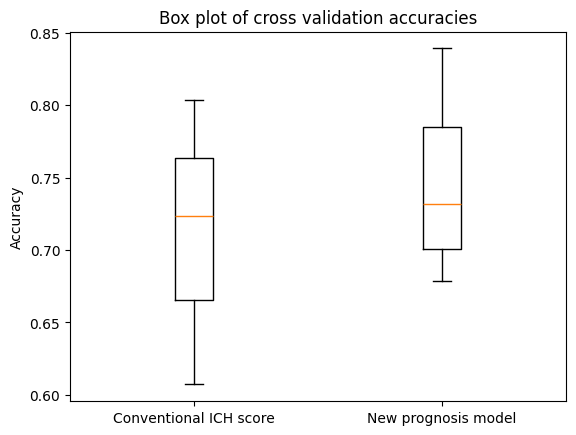

In [12]:
plt.boxplot([con_model_cv['test_score'], det_model_cv['test_score']])
plt.xticks([1, 2], ['Conventional ICH score', 'New prognosis model'])
plt.title('Box plot of cross validation accuracies')
plt.ylabel('Accuracy')
plt.show()

In [13]:
print(ttest_rel(con_model_cv['test_score'], det_model_cv['test_score']))

TtestResult(statistic=np.float64(-1.8960134604923162), pvalue=np.float64(0.09046278554832446), df=np.int64(9))


## Hold-out test model comparison

### Accuracy, Precision, Recall

In [14]:
con_pred = [[] for _ in range(10)]
det_pred = [[] for _ in range(10)]

for i in range(10):
    con_pred[i] = con_model_cv['estimator'][i].predict(X_con_test)
    det_pred[i] = det_model_cv['estimator'][i].predict(X_det_test)

In [15]:
# test_val = [[acc], [pre], [rec]]
con_test_val = [[], [], []]
det_test_val = [[], [], []]

for i in range(10):
    con_test_val[0].append(accuracy_score(y_test, con_pred[i]))
    det_test_val[0].append(accuracy_score(y_test, det_pred[i]))
    con_test_val[1].append(precision_score(y_test, con_pred[i], average='macro'))
    det_test_val[1].append(precision_score(y_test, det_pred[i], average='macro'))
    con_test_val[2].append(recall_score(y_test, con_pred[i], average='macro'))
    det_test_val[2].append(recall_score(y_test, det_pred[i], average='macro'))

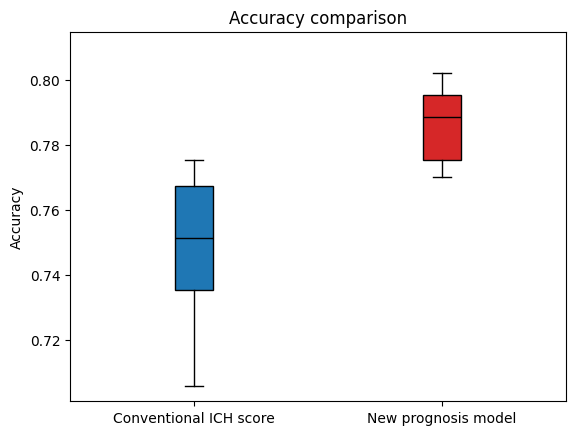

In [16]:
colors = ['tab:blue', 'tab:red']
boxp = plt.boxplot([con_test_val[0], det_test_val[0]],
            patch_artist=True, medianprops=dict(color='black', linewidth=1))
for patch, color in zip(boxp['boxes'], colors):
    patch.set_facecolor(color)
plt.xticks([1,2], ['Conventional ICH score', 'New prognosis model'])
plt.ylabel('Accuracy')
plt.ylim(top=0.815)
plt.title('Accuracy comparison')
# plt.savefig('hold_out_accuracies.png')
plt.show()

In [17]:
print(ttest_rel(con_test_val[0], det_test_val[0]))

TtestResult(statistic=np.float64(-5.5573622355411025), pvalue=np.float64(0.0003530693503893786), df=np.int64(9))


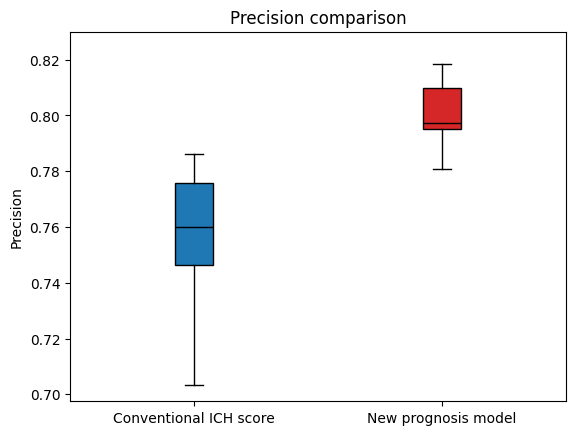

In [18]:
colors = ['tab:blue', 'tab:red']
boxp = plt.boxplot([con_test_val[1], det_test_val[1]],
            patch_artist=True, medianprops=dict(color='black', linewidth=1))
for patch, color in zip(boxp['boxes'], colors):
    patch.set_facecolor(color)
plt.xticks([1,2], ['Conventional ICH score', 'New prognosis model'])
plt.ylabel('Precision')
plt.ylim(top=0.83)
plt.title('Precision comparison')
# plt.savefig('hold_out_accuracies.png')
plt.show()

In [19]:
print(ttest_rel(con_test_val[1], det_test_val[1]))

TtestResult(statistic=np.float64(-5.005583809689883), pvalue=np.float64(0.0007333591376980003), df=np.int64(9))


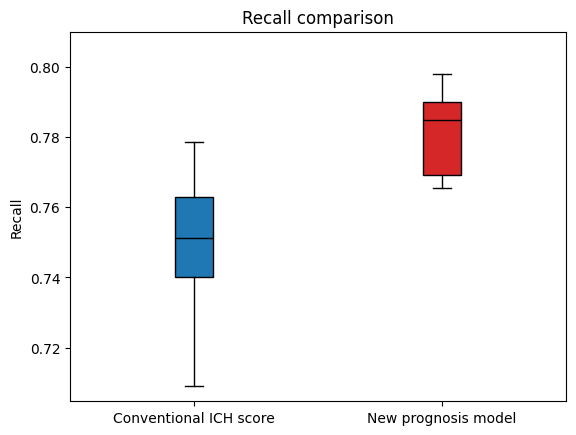

In [20]:
colors = ['tab:blue', 'tab:red']
boxp = plt.boxplot([con_test_val[2], det_test_val[2]],
            patch_artist=True, medianprops=dict(color='black', linewidth=1))
for patch, color in zip(boxp['boxes'], colors):
    patch.set_facecolor(color)
plt.xticks([1,2], ['Conventional ICH score', 'New prognosis model'])
plt.ylabel('Recall')
plt.ylim(top=0.81)
plt.title('Recall comparison')
# plt.savefig('hold_out_accuracies.png')
plt.show()

In [21]:
print(ttest_rel(con_test_val[2], det_test_val[2]))

TtestResult(statistic=np.float64(-4.427305252838976), pvalue=np.float64(0.0016535950386211387), df=np.int64(9))


### AUROC comparison

In [22]:
y_test_proba = label_binarize(y_test, classes=[0, 1, 2])
y_test_proba = np.array(y_test_proba)

In [23]:
con_pred_proba = [[] for _ in range(10)]
det_pred_proba = [[] for _ in range(10)]

for i in range(10):
    con_pred_proba[i] = con_model_cv['estimator'][i].predict_proba(X_con_test)
    det_pred_proba[i] = det_model_cv['estimator'][i].predict_proba(X_det_test)

con_pred_proba = np.array(con_pred_proba)
det_pred_proba = np.array(det_pred_proba)

In [24]:
# test_val_roc = [[class 0], [class 1], [class 2]]
con_test_val_roc = [[], [], []]
det_test_val_roc = [[], [], []]

for i in range(10):
    con_test_val_roc[0].append(roc_auc_score(y_test_proba[:, 0], con_pred_proba[i, :, 0]))
    det_test_val_roc[0].append(roc_auc_score(y_test_proba[:, 0], det_pred_proba[i, :, 0]))
    con_test_val_roc[1].append(roc_auc_score(y_test_proba[:, 1], con_pred_proba[i, :, 1]))
    det_test_val_roc[1].append(roc_auc_score(y_test_proba[:, 1], det_pred_proba[i, :, 1]))
    con_test_val_roc[2].append(roc_auc_score(y_test_proba[:, 2], con_pred_proba[i, :, 2]))
    det_test_val_roc[2].append(roc_auc_score(y_test_proba[:, 2], det_pred_proba[i, :, 2]))

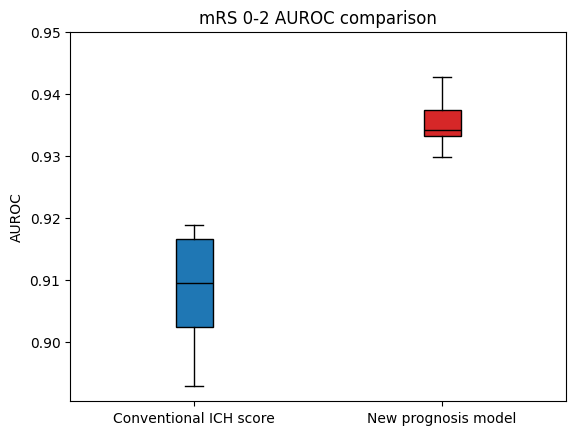

In [25]:
colors = ['tab:blue', 'tab:red']
boxp = plt.boxplot([con_test_val_roc[0], det_test_val_roc[0]],
            patch_artist=True, medianprops=dict(color='black', linewidth=1))
for patch, color in zip(boxp['boxes'], colors):
    patch.set_facecolor(color)
plt.xticks([1,2], ['Conventional ICH score', 'New prognosis model'])
plt.ylabel('AUROC')
plt.ylim(top=0.95)
plt.title('mRS 0-2 AUROC comparison')
# plt.savefig('hold_out_accuracies.png')
plt.show()

In [26]:
print(ttest_rel(con_test_val_roc[0], det_test_val_roc[0]))

TtestResult(statistic=np.float64(-8.747092643152131), pvalue=np.float64(1.0773575300620075e-05), df=np.int64(9))


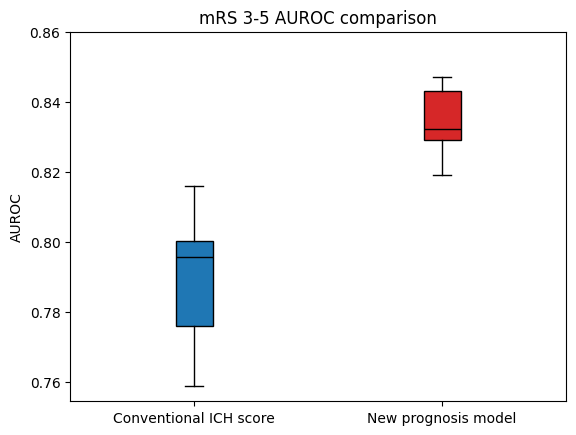

In [27]:
colors = ['tab:blue', 'tab:red']
boxp = plt.boxplot([con_test_val_roc[1], det_test_val_roc[1]],
            patch_artist=True, medianprops=dict(color='black', linewidth=1))
for patch, color in zip(boxp['boxes'], colors):
    patch.set_facecolor(color)
plt.xticks([1,2], ['Conventional ICH score', 'New prognosis model'])
plt.ylabel('AUROC')
plt.ylim(top=0.86)
plt.title('mRS 3-5 AUROC comparison')
# plt.savefig('hold_out_accuracies.png')
plt.show()

In [28]:
print(ttest_rel(con_test_val_roc[1], det_test_val_roc[1]))

TtestResult(statistic=np.float64(-7.4214112734786815), pvalue=np.float64(4.011443311659704e-05), df=np.int64(9))


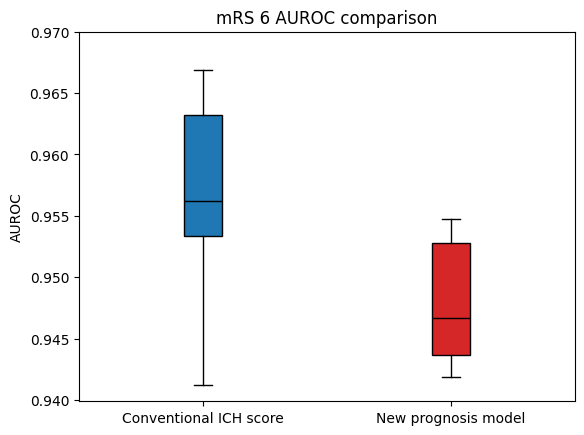

In [29]:
colors = ['tab:blue', 'tab:red']
boxp = plt.boxplot([con_test_val_roc[2], det_test_val_roc[2]],
            patch_artist=True, medianprops=dict(color='black', linewidth=1))
for patch, color in zip(boxp['boxes'], colors):
    patch.set_facecolor(color)
plt.xticks([1,2], ['Conventional ICH score', 'New prognosis model'])
plt.ylabel('AUROC')
plt.ylim(top=0.97)
plt.title('mRS 6 AUROC comparison')
# plt.savefig('hold_out_accuracies.png')
plt.show()

In [30]:
print(ttest_rel(con_test_val_roc[2], det_test_val_roc[2]))

TtestResult(statistic=np.float64(2.4492220126512465), pvalue=np.float64(0.03680365817303509), df=np.int64(9))
